In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

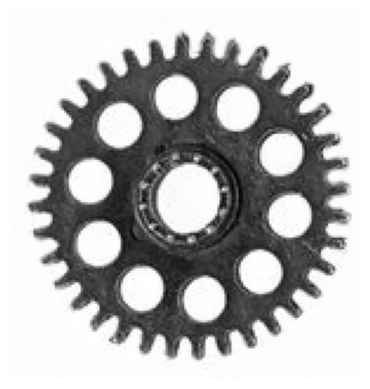

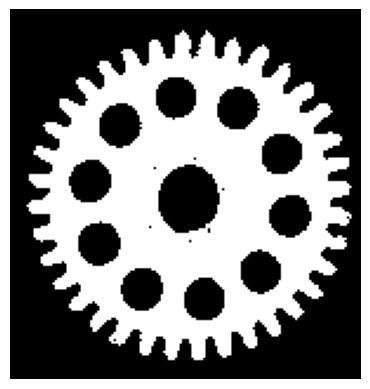

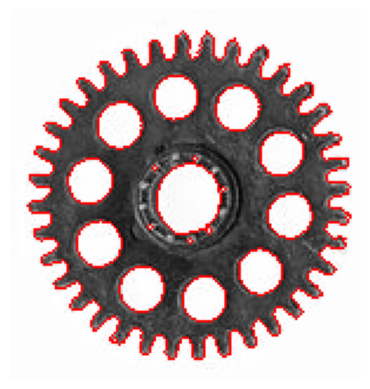

[(68.26419266350405, 1.4827889532671559), (59.033888572581766, 0.033885329904117606)]


In [2]:
def show_gray(img):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

def get_grad_and_cnts(img_path, threshold=100, cnt_idx=-1):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    show_gray(img)
    
    # Oblicz gradienty Sobela
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_magnitude /= np.amax(grad_magnitude)
    grad_orientation = np.rad2deg(np.arctan2(grad_y, grad_x))
    
    _, img_bin = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    img_bin = cv2.bitwise_not(img_bin)
    show_gray(img_bin)
    
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = cv2.merge([img, img, img])
    cv2.drawContours(img_contours, contours, cnt_idx, (255, 0, 0), 1)
    plt.imshow(img_contours)
    plt.axis("off")
    plt.show()
    
    moments = cv2.moments(img_bin, 1)
    m00, m01, m10 = moments['m00'], moments['m01'], moments['m10']
    center_y, center_x = int(m01 / m00), int(m10 / m00)  # y, x
    
    return grad_magnitude, grad_orientation, contours, center_y, center_x


def create_r_table(img_path, threshold=100, cnt_idx=-1):
    grad_magnitude, grad_orientation, contours, center_y, center_x = get_grad_and_cnts(img_path, threshold, cnt_idx)

    Rtable = [[] for _ in range(360)]
    # for cnts in contours:
    #     for cnt in cnts:
    for cnt in contours[0]:
            x, y = cnt[0]
            r_idx = int(grad_orientation[y, x])
            angle = np.arctan2(y - center_y, x - center_x)
            length = np.sqrt((x-center_x)**2 + (y-center_y)**2)
            Rtable[r_idx].append((length, angle))
        
    return Rtable, contours, center_x, center_y
    
Rtable, trybik_cnt, t1_center_x, t1_center_y = create_r_table("trybik.jpg", 220)
print(Rtable[30])
    

## Trybiki 2

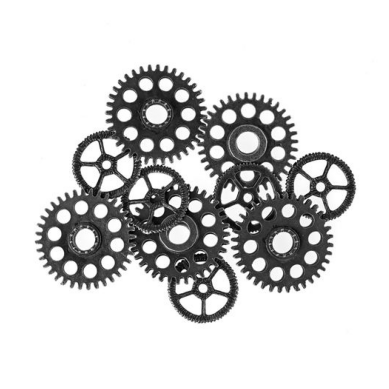

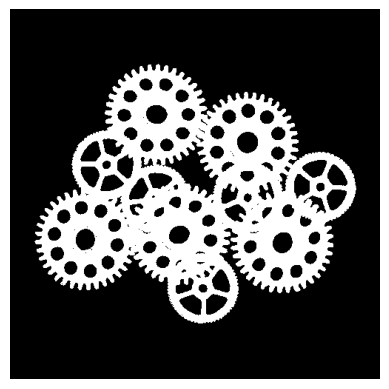

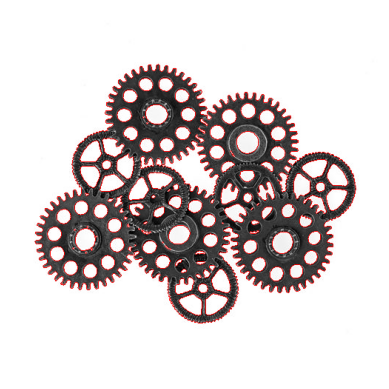

In [3]:
grad_magnitude, grad_orientation, contours, center_y, center_x = get_grad_and_cnts("trybiki2.jpg", 220, -1)

310 102


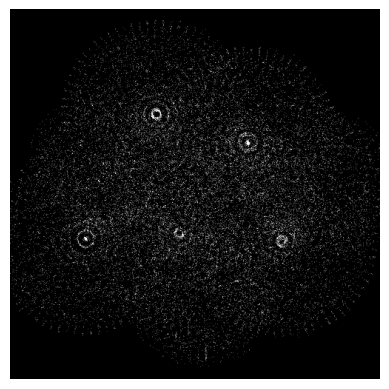

In [6]:
height, width = grad_magnitude.shape
hough = np.zeros((height, width))
for y, row in enumerate(grad_magnitude):
    for x, mag in enumerate(row):
        if mag > 0.5:
            r_idx = int(grad_orientation[y, x])
            r_idx = (r_idx + 360) % 360
            # if not Rtable[r_idx]:
            #     continue
            for dist, phi in Rtable[r_idx]:
                x1 = -dist * np.cos(phi) + x
                y1 = -dist * np.sin(phi) + y
                if y1 < height and y1 >= 0 and x1 < width and x1 >= 0: 
                    hough[int(y1), int(x1)] += 1
 
max_y, max_x = np.where(hough.max() == hough)
max_y, max_x = max_y[0], max_x[0]
print(max_y, max_x)

hough_img = np.clip(hough, 0, 3.7)
hough_img = cv2.normalize(hough_img, None, alpha=0, beta=255, dtype=cv2.CV_8U, norm_type=cv2.NORM_MINMAX)
plt.imshow(hough_img, cmap="gray")
plt.axis("off")
plt.show()

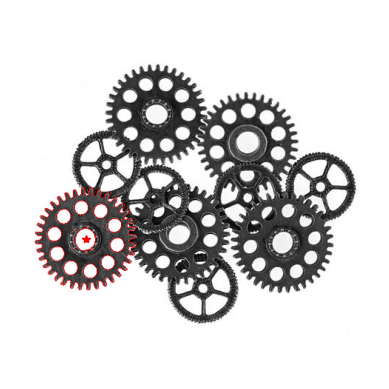

In [5]:
# trybik = cv2.imread("trybik.jpg")
trybiki2 = cv2.imread("trybiki2.jpg", cv2.IMREAD_GRAYSCALE)

plt.plot(max_x, max_y, 'r*')
img_contours = cv2.merge([trybiki2, trybiki2, trybiki2])
shifted_contours = list()
dx = max_x - int(t1_center_x)
dy = max_y - int(t1_center_y)
for cnts in trybik_cnt:
    shifted_contours.append(cnts + np.array([dx, dy]))

cv2.drawContours(img_contours, shifted_contours, -1, (255, 0, 0), 1)
plt.imshow(img_contours)
plt.axis("off")
plt.show()


